<a href="https://colab.research.google.com/github/Negfir/Bayesian-GA/blob/main/PGM_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # or any {'0', '1', '2'}
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import math 
from pomegranate import BayesianNetwork
import time
import numpy as np                
import pandas as pd                 
import plotly.graph_objects as go  
np.random.seed(1234)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import matplotlib.pyplot as plt
tf.debugging.set_log_device_placement(True)

tf.random.set_seed(
    7
)


Num GPUs Available:  1


In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [5]:
!pip install -U pymoo

Requirement already up-to-date: pymoo in /usr/local/lib/python3.7/dist-packages (0.4.2.2)


In [6]:
!pip install pomegranate
# !pip uninstall numpy
# !pip install numpy


     |████████████████████████████████| 17.9MB 1.2MB/s 
     |████████████████████████████████| 15.3MB 171kB/s 
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.20.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5


# Transformer block 

In [2]:

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [3]:

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


## Download and prepare dataset

In [4]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



25000 Training sequences
25000 Validation sequences


## Transformer function

In [6]:


from IPython.utils import io


def transformerFit(X):

    print("input is:",X)
    embed_dim = int((float(X[0])))
    num_heads = int((float(X[1])))
    ff_dim = int((float(X[2])))

    if embed_dim == 0 or num_heads == 0 or ff_dim == 0 :
      return [10,50]

    print("Variables are:",embed_dim ,num_heads,ff_dim)

    with io.capture_output() as captured:

      inputs = layers.Input(shape=(maxlen,))
      embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
      x = embedding_layer(inputs)
      transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
      x = transformer_block(x)
      x = layers.GlobalAveragePooling1D()(x)
      x = layers.Dropout(0.1)(x)
      x = layers.Dense(20, activation="relu")(x)
      x = layers.Dropout(0.1)(x)
      outputs = layers.Dense(2, activation="softmax")(x)

      model = keras.Model(inputs=inputs, outputs=outputs)



      model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
      batch = 32
      import time


      history = model.fit(
          x_train, y_train, batch_size=batch, epochs=2, verbose=0
      )


      start = time.time()

      results = model.evaluate(x_val, y_val, batch_size=batch)
 
    
    end = time.time()
    latency = end - start
    if results[1]<0.7:
      latency = latency*1.5
    print("latency, test acc:", latency, 100-(results[1]*100))
    return [latency, 100-(results[1]*100)]

# **Optimization**

## **EncoderDecoder Block**

In [8]:
from numpy import random


class EncoderDecoder:
  def __init__(self, decimal_rep, binary_rep):
    self.decimal_rep = np.array(decimal_rep)
    self.binary_rep = np.array(binary_rep)

  def encode(self,row):
    np.array(row)
    for i,r in enumerate(self.decimal_rep):
      if np.array_equal(r,row):
        return self.binary_rep[i]
    return self.binary_rep[random.randint(len(self.binary_rep))]
  
  def decode(self,row):
    np.array(row)
    for i,r in enumerate(self.binary_rep):
      
      if np.array_equal(r,row):
        return self.decimal_rep[i]
    return self.decimal_rep[random.randint(len(self.decimal_rep))]

  def getDecimal(self):
    return self.decimal_rep

  def getBinary(self):
    return self.binary_rep

  def setDecimal(self,inp):
    self.decimal_rep = inp

  def setBinary(self,inp):
   self.binary_rep = inp




In [9]:
embed_dim = [8, 16, 32, 64, 128, 256, 512, 768]
num_heads = [2, 3, 4, 5, 6, 8, 10, 12]
ff_dim = [4, 8, 16, 32, 64, 128, 256, 512]

def bitEncoder(var):
  lenght = len(var)
  encoded = []
  for i,v in enumerate(var):
      encoded.append(np.binary_repr(i, width=math.ceil(np.log2(lenght))))
  return encoded

def bitDecoder(var):
  lenght = len(var)
  decoded = []
  for i,v in enumerate(var):
      decoded.append(np.base_repr(i, 10))
  print( decoded)

bitEncoder(embed_dim)

['000', '001', '010', '011', '100', '101', '110', '111']

In [10]:



def sample(chromosome, sample_size):
    idx = np.random.randint(low=0, high=chromosome.shape[0], size=sample_size)
    initial_population = []
    
    for i in idx:
        # print("Selected samples are:",chromosome[i])
        fit = fitnessFunction(chromosome[i])
        print("############ FIT",fit)
        initial_population.append(list(np.append(chromosome[i],fit)))
    initial_population = np.asarray(initial_population)
    # print(initial_population)
    return initial_population


def getFitness(chromosome):
    initial_population = [] 
    for i in range(len(chromosome)):
        fit = fitnessFunction(chromosome[i])
        initial_population.append(list(np.append(chromosome[i],fit)))
    initial_population = np.asarray(initial_population)
    return initial_population

In [11]:
def non_dominated_sorting_algorithm(values1, values2):
    # print("valu1 and 2",values1, values2)
    S=[[] for i in range(0,len(values1))]
    front = [[]]
    n=[0 for i in range(0,len(values1))]
    rank = [0 for i in range(0, len(values1))]

    for p in range(0,len(values1)):
        S[p]=[]
        n[p]=0
        for q in range(0, len(values1)):
            if (values1[p] < values1[q] and values2[p] < values2[q]) or (values1[p] <= values1[q] and values2[p] < values2[q]) or (values1[p] < values1[q] and values2[p] <= values2[q]):
                if q not in S[p]:
                    S[p].append(q)
            elif (values1[q] < values1[p] and values2[q] < values2[p]) or (values1[q] <= values1[p] and values2[q] < values2[p]) or (values1[q] < values1[p] and values2[q] <= values2[p]):
                n[p] = n[p] + 1
        if n[p]==0:
            rank[p] = 0
            if p not in front[0]:
                front[0].append(p)
    i = 0
    while(front[i] != []):
        Q=[]
        for p in front[i]:
            for q in S[p]:
                n[q] =n[q] - 1
                if( n[q]==0):
                    rank[q]=i+1
                    if q not in Q:
                        Q.append(q)
        i = i+1
        front.append(Q)
    del front[len(front)-1]
    return front

In [12]:
pareto_fronts = []

def NDS(X, slice):
  X = X.values

  width = X.shape[1]-1
  idx = non_dominated_sorting_algorithm(X[:,width-1],X[:,width])
  
  # print(X)
  new_pop = []#np.empty([slice,X.shape[1]])
  cnt = 0
  pareto = X[list(idx[0]),:]
  pareto_fronts.append(pareto)
  print("front is", pareto)
  for front in idx:
    for i in front:
      if cnt < slice:
        # print(X[i])
        new_pop.append(list(X[i]))
  new_pop = np.array(new_pop)
  # print(new_pop)
  return new_pop,pareto

In [ ]:
values1 = ['1','6','3','4']
values2 = ['5','6','7','8']
non_dominated_sorting_algorithm(values1, values2)

[[0], [1, 2], [3]]

In [13]:
!apt install libgraphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 34 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.32-1ubuntu1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-0 amd64 2.24.32-1ubuntu1 [1,769 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main

In [14]:
def sortSelect(population, percentage, isMO = True):
    X_raw = pd.DataFrame(population)
    X_raw = X_raw.drop_duplicates()
    width = population.shape[1]-1
 
    if (not isMO):
      X_raw = X_raw.sort_values(by=[population.shape[1]-1])

      X_raw = X_raw.drop(columns=[width]).values
      slice_ = percentage#math.floor(population.shape[0]*percentage)
      top_pop = X_raw[:slice_]

    else:
   
      slice_ = percentage#math.floor(population.shape[0]*percentage)
      # print(X_raw)
      topGenes, pareto = NDS(X_raw,slice_)
      # print(topGenes)
      X_raw = pd.DataFrame(topGenes)
      # print("shape is",X_raw.values.shape)
      X_raw = X_raw.drop(columns=[width])
 
      X_raw = X_raw.drop(columns=[width-1]).values
 
      top_pop = X_raw
      

    return top_pop,pareto 

def binaryEncoder(chrom):
    pop = []   
    for n in chrom:
        arr = []
        bin = data.encode(n)
        for item in bin:
          digits =  [x for x in str(item)]
          arr = np.append(arr,digits)
        pop.append(list(arr))
    return pop


def seperator(stringIn,NUM_VARIABLES,VAR_SIZE):
  tmp = []
  for i in range(NUM_VARIABLES):
    tmp.append( [''.join(stringIn[VAR_SIZE*i:VAR_SIZE*i+VAR_SIZE])])
  return([j for sub in tmp for j in sub])



In [15]:

from pomegranate import BayesianNetwork



# print("Greedy")
# print("Time (s): ", t)
# print("P(D|M): ", p)
# model.plot()

embed_dim = [2,4,6,8,10,16,32,64]
num_heads = [1,2,3,4,5,6,7,8]
ff_dim = [2,4,6,8,10,16,32,64]

NUM_VARIABLES = 2
VAR_SIZE = 3

variables = np.array(
  np.meshgrid(embed_dim, num_heads, ff_dim)).T.reshape(-1, 3)




# var1 = np.array([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
# var2 = np.array([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
# var3 = np.array([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])

NUM_VARIABLES = 3

begin = -5
end = 5
inc = (end-begin)/15
inc1 = 5/15
inc2=3/15


var1 = np.arange(start=begin, stop=end + inc, step=inc)
var2 = np.arange(start=begin, stop=end + inc, step=inc)
var3 = np.arange(start=begin, stop=end + inc, step=inc)

var1 = np.arange(start=0, stop=5 + inc, step=inc1)
var2 = np.arange(start=0, stop=3 + inc, step=inc2)

# var1_bin = bitEncoder(var1)
# var2_bin = bitEncoder(var2)
# var3_bin = bitEncoder(var3)


embed_dim = np.array(['2','4','6','8','10','16','32','64'])
num_heads = np.array(['1','2','3','4'])
ff_dim = np.array(['2','4','6','8','10','16','32','64'])

var1_bin = bitEncoder(embed_dim)
var2_bin = bitEncoder(num_heads)
var3_bin = bitEncoder(ff_dim)

# variables = np.array(
#   np.meshgrid(var1, var2)).T.reshape(-1, NUM_VARIABLES)
# variables_bin = np.array(
#   np.meshgrid(var1_bin, var2_bin)).T.reshape(-1, NUM_VARIABLES)


variables = np.array(
  np.meshgrid(embed_dim, num_heads, ff_dim)).T.reshape(-1, NUM_VARIABLES)
variables_bin = np.array(
  np.meshgrid(var1_bin, var2_bin, var3_bin)).T.reshape(-1, NUM_VARIABLES)

data = EncoderDecoder(variables,variables_bin)

####################################################


def bayesianOptimizer(variables,algorithm='greedy' ,POP_SIZE=40,gens=4):
    # POP_SIZE = 40
    new_pop = variables
    # population = sample(new_pop, POP_SIZE)
    # df = pd.DataFrame(population).to_csv("gdrive/MyDrive/out.csv")
    population = pd.read_csv("gdrive/MyDrive/out.csv").to_numpy()[:,1:6]
    print(population)
    population[:,4] = 100+100*population[:,4]
    print(population)
    paretoFront = []
    chrom,pareto_ = sortSelect(population,int(POP_SIZE*0.5),True)
    bbb = pd.DataFrame(chrom).to_csv("chrom.csv")
    POP_SIZE = int(POP_SIZE*0.5)
    # print(chrom)
    tic = time.time()

    

    for generation in range(gens):
        print("Generation:",generation, "...")
        X = binaryEncoder(chrom)

        model = BayesianNetwork.from_samples(X, algorithm=algorithm) 
        model.plot()
        p = model.log_probability(X).sum()

        BO_size = int(POP_SIZE*0.7)
        sampled = model.sample(BO_size)
        child = []
        for c in sampled: 
          child.append(list(data.decode(seperator(c,NUM_VARIABLES,VAR_SIZE))))
        # print(child)
        print(len(child))
        old_size = POP_SIZE - BO_size
        idx = np.random.randint(low=0, high=variables.shape[0], size=old_size-int(old_size*0.75))

        # print("*****",chrom)
        new_pop =  np.concatenate((np.array(child),chrom[0:int(old_size)]), axis=0)
        ft = getFitness(new_pop)
        if generation < gens-1:
          chrom,pareto = sortSelect(ft,int(POP_SIZE*0.5),True) 
        paretoFront.append(pareto)

        print(len(new_pop))
        


    latency = time.time() - tic
    print("total time is",latency)
    return chrom,ft,paretoFront
f1 = []
f2 = []


# for c in chrom:
#   f1.append(fitnessFunction(c)[1])
#   f2.append(fitnessFunction(c)[0])
#   # print(list(problem.evaluate(c)),c)
# plt.scatter(f2, f1, marker='o')
# f1_ = np.array(f1)
# f2_ = np.array(f2)
# idx = non_dominated_sorting_algorithm(f1, f2)
# f1_ = f1_[list(idx[0])]
# f2_ = f2_[list(idx[0])]

# plt.scatter(f2_, f1_, marker='o')

[[ 8.          4.          4.          2.72891021 12.79199719]
 [10.          4.         32.          2.71375394 12.56399751]
 [ 4.          3.          4.          2.48984957 12.52400279]
 [16.          2.          4.          2.48690081 12.60399818]
 [ 8.          1.         32.          2.2748208  12.81599998]
 [16.          1.          8.          2.46327949 12.4119997 ]
 [32.          1.         10.          2.4555335  12.60799766]
 [32.          2.         64.          2.65657949 12.46799827]
 [ 8.          4.         10.          2.6352818  12.85600066]
 [10.          2.         16.          2.42994308 12.41999865]
 [16.          4.          2.          2.77336669 13.40799928]
 [ 6.          2.         64.          2.37282181 12.68000007]
 [32.          3.         10.          2.78967023 12.63599992]
 [64.          3.          2.          3.08817863 12.86399961]
 [ 6.          4.         16.          2.59037018 12.48000264]
 [64.          3.         10.          3.08473492 12.63

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2453: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



latency, test acc: 3.666855812072754 50.0
input is: ['2' '4' '10']
Variables are: 2 4 10
latency, test acc: 3.873208522796631 49.36000108718872
input is: ['64' '3' '8']
Variables are: 64 3 8
latency, test acc: 3.1957972049713135 12.572002410888672
input is: ['4' '1' '16']
Variables are: 4 1 16
latency, test acc: 2.2957375049591064 12.68799901008606
input is: ['6' '1' '10']
Variables are: 6 1 10
latency, test acc: 2.559490203857422 12.352001667022705
input is: ['64' '3' '16']
Variables are: 64 3 16
latency, test acc: 3.127427816390991 13.248002529144287
input is: ['6' '4' '16']
Variables are: 6 4 16
latency, test acc: 2.660346269607544 12.388002872467041
input is: ['16' '1' '64']
Variables are: 16 1 64
latency, test acc: 2.4138033390045166 12.787997722625732
input is: ['10' '4' '8']
Variables are: 10 4 8
latency, test acc: 2.75557279586792 12.624001502990723
input is: ['10' '2' '10']
Variables are: 10 2 10
latency, test acc: 2.4753379821777344 12.41999864578247
input is: ['8.0' '1.0' '3

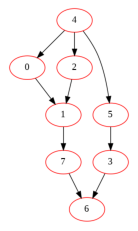

In [23]:
def fitnessFunction (X):
  return transformerFit(X)
chrom,ft,paretoFront = bayesianOptimizer(variables,algorithm='greedy' ,POP_SIZE=30,gens=4)
bbb = pd.DataFrame(ft).to_csv("gdrive/MyDrive/fit_greedy_4_3.csv")

[[5, 10, 11, 14], [0, 13, 2], [7, 9], [3, 12], [1, 8], [4, 6]]


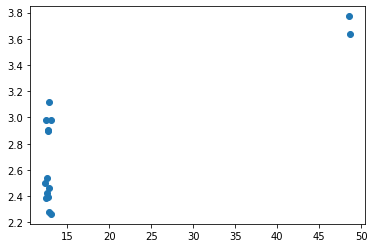

In [43]:
ft = pd.read_csv("gdrive/MyDrive/fit_greedy_4.csv").to_numpy()[:,1:6]

f1 =list(ft[:,3].astype(float))
f2 = list(ft[:,4].astype(float))


plt.scatter(list(f2), list(f1), marker='o')
f1_ = np.array(f1)
f2_ = np.array(f2)
idx = non_dominated_sorting_algorithm(f1, f2)
print(idx)


[[ 2.39063072  3.11641073  2.98046398  2.89342737  3.63758218  2.2805872
   3.77264142  2.54137087  2.97999382  2.4607451   2.38651729  2.26373482
   2.90440464  2.42222118  2.50330067]
 [12.7399981  12.8279984  12.50399947 12.72000074 48.65999818 12.84400225
  48.61199856 12.62000203 13.07600141 12.81599998 12.49600053 13.08000088
  12.67200112 12.59599924 12.38800287]]


Text(0.5, 1.0, 'Transformer optimization')

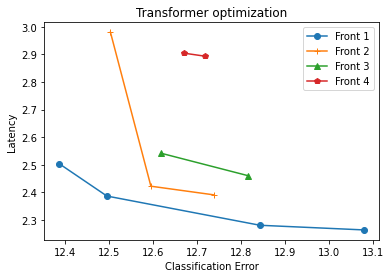

In [44]:
# sorted_array = an_array[numpy.argsort(an_array[:, 1])]

frontx = np.array(f1)
fronty = np.array(f2)

front = np.array([f1,f2])
# pd.DataFrame(front).to_csv("front.csv")

f1_ = frontx[list(idx[0])]
f2_ = fronty[list(idx[0])]
indexs_to_order_by = f1_.argsort()
f1_ = f1_[indexs_to_order_by]
f2_ = f2_[indexs_to_order_by]

front_greedy1 = f1_
front_greedy2 = f2_
# pd.DataFrame([f1_,f2_]).to_csv("front1.csv")

print(front)

# plt.ylim(12,15)
plt.plot(f2_, f1_, marker='o')


f1_ = frontx[list(idx[1])]
f2_ = fronty[list(idx[1])]
indexs_to_order_by = f1_.argsort()
f1_ = f1_[indexs_to_order_by]
f2_ = f2_[indexs_to_order_by]
plt.plot(f2_, f1_, marker='+')

f1_ = frontx[list(idx[2])]
f2_ = fronty[list(idx[2])]
indexs_to_order_by = f1_.argsort()
f1_ = f1_[indexs_to_order_by]
f2_ = f2_[indexs_to_order_by]
plt.plot(f2_, f1_, marker='^')

f1_ = frontx[list(idx[3])]
f2_ = fronty[list(idx[3])]
indexs_to_order_by = f1_.argsort()
f1_ = f1_[indexs_to_order_by]
f2_ = f2_[indexs_to_order_by]
plt.plot(f2_, f1_, marker='p')
plt.legend(['Front 1', 'Front 2', 'Front 3', 'Front 4'], loc='best')
plt.ylabel('Latency')
plt.xlabel('Classification Error')
plt.title('Transformer optimization')

[[ 8.          4.          4.          2.72891021 12.79199719]
 [10.          4.         32.          2.71375394 12.56399751]
 [ 4.          3.          4.          2.48984957 12.52400279]
 [16.          2.          4.          2.48690081 12.60399818]
 [ 8.          1.         32.          2.2748208  12.81599998]
 [16.          1.          8.          2.46327949 12.4119997 ]
 [32.          1.         10.          2.4555335  12.60799766]
 [32.          2.         64.          2.65657949 12.46799827]
 [ 8.          4.         10.          2.6352818  12.85600066]
 [10.          2.         16.          2.42994308 12.41999865]
 [16.          4.          2.          2.77336669 13.40799928]
 [ 6.          2.         64.          2.37282181 12.68000007]
 [32.          3.         10.          2.78967023 12.63599992]
 [64.          3.          2.          3.08817863 12.86399961]
 [ 6.          4.         16.          2.59037018 12.48000264]
 [64.          3.         10.          3.08473492 12.63

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2453: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



latency, test acc: 2.9152069091796875 12.58000135421753
input is: ['2' '4' '32']
Variables are: 2 4 32
latency, test acc: 3.8816245794296265 47.90400266647339
input is: ['8' '2' '4']
Variables are: 8 2 4
latency, test acc: 2.3938684463500977 12.92799711227417
input is: ['16' '2' '64']
Variables are: 16 2 64
latency, test acc: 2.513787269592285 13.248002529144287
input is: ['64' '1' '64']
Variables are: 64 1 64
latency, test acc: 2.6106433868408203 13.200002908706665
input is: ['2' '2' '64']
Variables are: 2 2 64
latency, test acc: 3.5067694187164307 50.0
input is: ['8' '3' '8']
Variables are: 8 3 8
latency, test acc: 2.534367322921753 12.68399953842163
input is: ['10' '4' '16']
Variables are: 10 4 16
latency, test acc: 2.7125792503356934 12.727999687194824
input is: ['8' '2' '4']
Variables are: 8 2 4
latency, test acc: 2.375359058380127 13.447999954223633
input is: ['64' '2' '4']
Variables are: 64 2 4
latency, test acc: 2.9189116954803467 12.752002477645874
input is: ['8.0' '1.0' '32.0

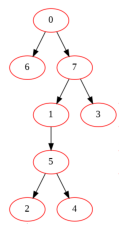

In [32]:
def fitnessFunction (X):
  return transformerFit(X)
chrom,ft,paretoFront = bayesianOptimizer(variables,algorithm='chow-liu' ,POP_SIZE=30,gens=4)
bbb = pd.DataFrame(ft).to_csv("gdrive/MyDrive/‘chowliu’_4_3.csv")

[[4, 8, 11, 13, 14], [5, 1, 10, 12], [0, 6], [2], [3], [9], [7]]


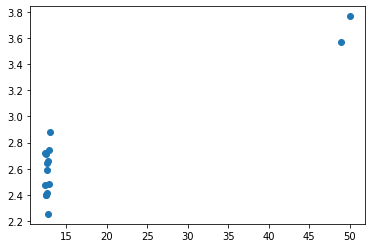

In [35]:
ft = pd.read_csv("gdrive/MyDrive/‘chowliu’_4.csv").to_numpy()[:,1:6]

f1 =list(ft[:,3].astype(float))
f2 = list(ft[:,4].astype(float))


plt.scatter(list(f2), list(f1), marker='o')
f1_ = np.array(f1)
f2_ = np.array(f2)
idx = non_dominated_sorting_algorithm(f1, f2)
print(idx)


Text(0.5, 1.0, 'Transformer optimization')

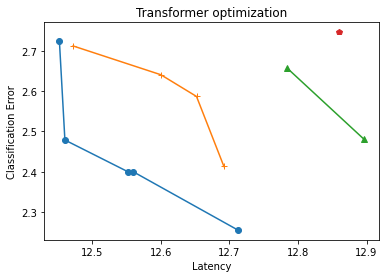

In [37]:
# sorted_array = an_array[numpy.argsort(an_array[:, 1])]

frontx = np.array(f1)
fronty = np.array(f2)

front = np.array([f1,f2])
# pd.DataFrame(front).to_csv("front.csv")

f1_ = frontx[list(idx[0])]
f2_ = fronty[list(idx[0])]
indexs_to_order_by = f1_.argsort()
f1_ = f1_[indexs_to_order_by]
f2_ = f2_[indexs_to_order_by]
# pd.DataFrame([f1_,f2_]).to_csv("front1.csv")

front_chiu1 = f1_
front_chiu2 = f2_
# plt.ylim(12,15)
plt.plot(f2_, f1_, marker='o')


f1_ = frontx[list(idx[1])]
f2_ = fronty[list(idx[1])]
indexs_to_order_by = f1_.argsort()
f1_ = f1_[indexs_to_order_by]
f2_ = f2_[indexs_to_order_by]
plt.plot(f2_, f1_, marker='+')

f1_ = frontx[list(idx[2])]
f2_ = fronty[list(idx[2])]
indexs_to_order_by = f1_.argsort()
f1_ = f1_[indexs_to_order_by]
f2_ = f2_[indexs_to_order_by]
plt.plot(f2_, f1_, marker='^')

f1_ = frontx[list(idx[3])]
f2_ = fronty[list(idx[3])]
indexs_to_order_by = f1_.argsort()
f1_ = f1_[indexs_to_order_by]
f2_ = f2_[indexs_to_order_by]
plt.plot(f2_, f1_, marker='p')

plt.xlabel('Latency')
plt.ylabel('Classification Error')
plt.title('Transformer optimization')

Text(0.5, 1.0, 'Pareto Fronts')

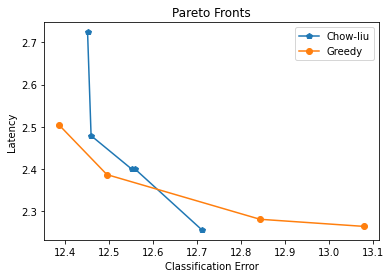

In [48]:
plt.plot(front_chiu2, front_chiu1, marker='p')
plt.plot(front_greedy2, front_greedy1, marker='o')
plt.legend(['Chow-liu', 'Greedy'], loc='best')
plt.ylabel('Latency')
plt.xlabel('Classification Error')
plt.title('Pareto Fronts')

In [62]:

from pomegranate import BayesianNetwork
from pomegranate import DiscreteDistribution


# print("Greedy")
# print("Time (s): ", t)
# print("P(D|M): ", p)
# model.plot()

embed_dim = [2,4,6,8,10,16,32,64]
num_heads = [1,2,3,4,5,6,7,8]
ff_dim = [2,4,6,8,10,16,32,64]

NUM_VARIABLES = 2
VAR_SIZE = 3

variables = np.array(
  np.meshgrid(embed_dim, num_heads, ff_dim)).T.reshape(-1, 3)




# var1 = np.array([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
# var2 = np.array([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
# var3 = np.array([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])

NUM_VARIABLES = 3

begin = -5
end = 5
inc = (end-begin)/15
inc1 = 5/15
inc2=3/15


var1 = np.arange(start=begin, stop=end + inc, step=inc)
var2 = np.arange(start=begin, stop=end + inc, step=inc)
var3 = np.arange(start=begin, stop=end + inc, step=inc)

var1 = np.arange(start=0, stop=5 + inc, step=inc1)
var2 = np.arange(start=0, stop=3 + inc, step=inc2)

# var1_bin = bitEncoder(var1)
# var2_bin = bitEncoder(var2)
# var3_bin = bitEncoder(var3)


embed_dim = np.array(['2','4','6','8','10','16','32','64'])
num_heads = np.array(['1','2','3','4'])
ff_dim = np.array(['2','4','6','8','10','16','32','64'])

var1_bin = bitEncoder(embed_dim)
var2_bin = bitEncoder(num_heads)
var3_bin = bitEncoder(ff_dim)

# variables = np.array(
#   np.meshgrid(var1, var2)).T.reshape(-1, NUM_VARIABLES)
# variables_bin = np.array(
#   np.meshgrid(var1_bin, var2_bin)).T.reshape(-1, NUM_VARIABLES)


variables = np.array(
  np.meshgrid(embed_dim, num_heads, ff_dim)).T.reshape(-1, NUM_VARIABLES)
variables_bin = np.array(
  np.meshgrid(var1_bin, var2_bin, var3_bin)).T.reshape(-1, NUM_VARIABLES)

data = EncoderDecoder(variables,variables_bin)

####################################################


def normalOptimizer(variables,POP_SIZE=40,gens=4):
    # POP_SIZE = 40
    new_pop = variables
    # population = sample(new_pop, POP_SIZE)
    # df = pd.DataFrame(population).to_csv("out.csv")
    population = pd.read_csv("gdrive/MyDrive/out.csv").to_numpy()[:,1:6]
    print(population)
    population[:,4] = 100+100*population[:,4]
    print(population)
    paretoFront = []
    chrom,pareto_ = sortSelect(population,int(POP_SIZE*0.5),True)
    bbb = pd.DataFrame(chrom).to_csv("chrom.csv")
    POP_SIZE = int(POP_SIZE*0.5)
    # print(chrom)
    tic = time.time()

    

    for generation in range(gens):
        print("Generation:",generation, "...")
        X = binaryEncoder(chrom)

        model = DiscreteDistribution.from_samples(X)
        model.plot()
        p = model.log_probability(X).sum()

        BO_size = int(POP_SIZE*0.7)
        sampled = model.sample(BO_size)
        print("*****",sampled)
        child = []
        for c in sampled: 
          child.append(list(data.decode(seperator(c,NUM_VARIABLES,VAR_SIZE))))
        # print(child)
        print(len(child))
        old_size = POP_SIZE - BO_size
        idx = np.random.randint(low=0, high=variables.shape[0], size=old_size-int(old_size*0.75))

        # print("*****",chrom)
        new_pop =  np.concatenate((np.array(child),chrom[0:int(old_size)]), axis=0)
        ft = getFitness(new_pop)
        if generation < gens-1:
          chrom,pareto = sortSelect(ft,int(POP_SIZE*0.5),True) 
        paretoFront.append(pareto)

        print(len(new_pop))
        


    latency = time.time() - tic
    print("total time is",latency)
    return chrom,ft,paretoFront
f1 = []
f2 = []


# for c in chrom:
#   f1.append(fitnessFunction(c)[1])
#   f2.append(fitnessFunction(c)[0])
#   # print(list(problem.evaluate(c)),c)
# plt.scatter(f2, f1, marker='o')
# f1_ = np.array(f1)
# f2_ = np.array(f2)
# idx = non_dominated_sorting_algorithm(f1, f2)
# f1_ = f1_[list(idx[0])]
# f2_ = f2_[list(idx[0])]

# plt.scatter(f2_, f1_, marker='o')

In [66]:
def fitnessFunction (X):
  return transformerFit(X)
chrom,ft,paretoFront = normalOptimizer(variables,POP_SIZE=30,gens=4)
bbb = pd.DataFrame(ft).to_csv("gdrive/MyDrive/fit_normal.csv")

[[ 8.          4.          4.          2.72891021 12.79199719]
 [10.          4.         32.          2.71375394 12.56399751]
 [ 4.          3.          4.          2.48984957 12.52400279]
 [16.          2.          4.          2.48690081 12.60399818]
 [ 8.          1.         32.          2.2748208  12.81599998]
 [16.          1.          8.          2.46327949 12.4119997 ]
 [32.          1.         10.          2.4555335  12.60799766]
 [32.          2.         64.          2.65657949 12.46799827]
 [ 8.          4.         10.          2.6352818  12.85600066]
 [10.          2.         16.          2.42994308 12.41999865]
 [16.          4.          2.          2.77336669 13.40799928]
 [ 6.          2.         64.          2.37282181 12.68000007]
 [32.          3.         10.          2.78967023 12.63599992]
 [64.          3.          2.          3.08817863 12.86399961]
 [ 6.          4.         16.          2.59037018 12.48000264]
 [64.          3.         10.          3.08473492 12.63

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2453: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



IndexError: ignored

NameError: ignored

In [80]:

from pomegranate import BayesianNetwork



# print("Greedy")
# print("Time (s): ", t)
# print("P(D|M): ", p)
# model.plot()

embed_dim = [2,4,6,8,10,16,32,64]
num_heads = [1,2,3,4,5,6,7,8]
ff_dim = [2,4,6,8,10,16,32,64]

NUM_VARIABLES = 2
VAR_SIZE = 3

variables = np.array(
  np.meshgrid(embed_dim, num_heads, ff_dim)).T.reshape(-1, 3)




# var1 = np.array([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
# var2 = np.array([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
# var3 = np.array([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])

NUM_VARIABLES = 2

begin = -5
end = 5
inc = (end-begin)/15
inc1 = 5/15
inc2=3/15


var1 = np.arange(start=begin, stop=end + inc, step=inc)
var2 = np.arange(start=begin, stop=end + inc, step=inc)
var3 = np.arange(start=begin, stop=end + inc, step=inc)

var1 = np.arange(start=0, stop=5 + inc, step=inc1)
var2 = np.arange(start=0, stop=3 + inc, step=inc2)

var1_bin = bitEncoder(var1)
var2_bin = bitEncoder(var2)
# var3_bin = bitEncoder(var3)


# embed_dim = np.array(['2','4','6','8','10','16','32','64'])
# num_heads = np.array(['1','2','3','4'])
# ff_dim = np.array(['2','4','6','8','10','16','32','64'])

# var1_bin = bitEncoder(embed_dim)
# var2_bin = bitEncoder(num_heads)
# var3_bin = bitEncoder(ff_dim)

variables = np.array(
  np.meshgrid(var1, var2)).T.reshape(-1, NUM_VARIABLES)
variables_bin = np.array(
  np.meshgrid(var1_bin, var2_bin)).T.reshape(-1, NUM_VARIABLES)


# variables = np.array(
#   np.meshgrid(embed_dim, num_heads, ff_dim)).T.reshape(-1, NUM_VARIABLES)
# variables_bin = np.array(
#   np.meshgrid(var1_bin, var2_bin, var3_bin)).T.reshape(-1, NUM_VARIABLES)

data = EncoderDecoder(variables,variables_bin)

####################################################


def bayesianOptimizer(variables,algorithm='greedy' ,POP_SIZE=40,gens=4):
    # POP_SIZE = 40
    new_pop = variables
    population = sample(new_pop, POP_SIZE)
    # df = pd.DataFrame(population).to_csv("gdrive/MyDrive/out.csv")
    # population = pd.read_csv("gdrive/MyDrive/out.csv").to_numpy()[:,1:6]
    # print(population)
    # population[:,4] = 100+100*population[:,4]
    # print(population)
    paretoFront = []
    chrom,pareto_ = sortSelect(population,int(POP_SIZE*0.5),True)
    # bbb = pd.DataFrame(chrom).to_csv("chrom.csv")
    POP_SIZE = int(POP_SIZE*0.5)
    # print(chrom)
    tic = time.time()

    

    for generation in range(gens):
        print("Generation:",generation, "...")
        X = binaryEncoder(chrom)

        model = BayesianNetwork.from_samples(X, algorithm=algorithm) 
        model.plot()
        p = model.log_probability(X).sum()

        BO_size = int(POP_SIZE*0.7)
        sampled = model.sample(BO_size)
        child = []
        for c in sampled: 
          child.append(list(data.decode(seperator(c,NUM_VARIABLES,VAR_SIZE))))
        # print(child)
        print(len(child))
        old_size = POP_SIZE - BO_size
        idx = np.random.randint(low=0, high=variables.shape[0], size=old_size-int(old_size*0.75))

        # print("*****",chrom)
        new_pop =  np.concatenate((np.array(child),chrom[0:int(old_size)]), axis=0)
        ft = getFitness(new_pop)
        if generation < gens-1:
          chrom,pareto = sortSelect(ft,int(POP_SIZE*0.5),True) 
        paretoFront.append(pareto)

        print(len(new_pop))
        


    latency = time.time() - tic
    print("total time is",latency)
    return chrom,ft,paretoFront
f1 = []
f2 = []


# for c in chrom:
#   f1.append(fitnessFunction(c)[1])
#   f2.append(fitnessFunction(c)[0])
#   # print(list(problem.evaluate(c)),c)
# plt.scatter(f2, f1, marker='o')
# f1_ = np.array(f1)
# f2_ = np.array(f2)
# idx = non_dominated_sorting_algorithm(f1, f2)
# f1_ = f1_[list(idx[0])]
# f2_ = f2_[list(idx[0])]

# plt.scatter(f2_, f1_, marker='o')

############ FIT [5.760000000000002, 39.44]
############ FIT [48.07111111111112, 16.684444444444445]
############ FIT [98.1511111111111, 7.204444444444443]
############ FIT [79.1111111111111, 16.444444444444446]
############ FIT [101.44, 19.360000000000003]
############ FIT [180.28444444444443, 2.4044444444444433]
############ FIT [36.16, 27.04]
############ FIT [32.44444444444444, 21.444444444444446]
############ FIT [146.24, 2.5599999999999987]
############ FIT [165.61777777777777, 2.0711111111111107]
############ FIT [13.404444444444445, 32.01777777777778]
############ FIT [17.351111111111113, 25.004444444444445]
############ FIT [131.36, 4.839999999999999]
############ FIT [80.81777777777778, 7.537777777777778]
############ FIT [53.35111111111112, 16.004444444444445]
############ FIT [103.11111111111109, 9.11111111111111]
############ FIT [36.284444444444446, 18.404444444444444]
############ FIT [123.11111111111109, 4.111111111111112]
############ FIT [68.0, 17.0]
############ FIT 

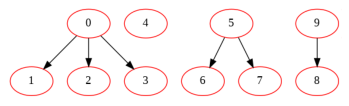

In [140]:
def fitnessFunction (X):
  return list(problem.evaluate(X)[0])
  # return transformerFit(X)

chrom,ft,paretoFront = bayesianOptimizer(variables,algorithm='greedy' ,POP_SIZE=200,gens=4)


(100, 4)
[[0, 8, 19, 21, 30, 34, 35, 37, 41, 42, 46, 47, 56, 57, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99], [92, 45, 59, 53, 32, 54, 69, 49, 61, 67, 63, 1, 68, 60, 40, 52, 5, 25, 50, 2, 28], [15, 36, 33, 58, 13, 9, 14, 12, 26, 11, 62, 29], [31, 64, 65, 51, 48, 6, 4, 24], [18, 23, 20, 17], [7, 16, 44, 10, 22, 39, 66], [38, 55, 27, 3], [43]]


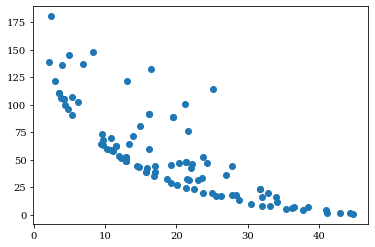

In [141]:
# ft = pd.read_csv("gdrive/MyDrive/fit_greedy_4.csv").to_numpy()[:,1:6]
print(ft.shape)
f1 =list(ft[:,2].astype(float))
f2 = list(ft[:,3].astype(float))


plt.scatter(list(f2), list(f1), marker='o')
f1_ = np.array(f1)
f2_ = np.array(f2)
idx = non_dominated_sorting_algorithm(f1, f2)
print(idx)


[[  5.44        62.24        68.01777778 100.64       121.61777778
   16.         147.80444444  48.01777778  48.81777778  59.53777778
   91.11111111  64.01777778  42.73777778 145.13777778  43.84
    7.27111111  48.01777778  80.87111111  47.00444444  51.48444444
   44.44444444  16.87111111  88.55111111  45.88444444  71.84
   16.16        33.13777778 132.44444444  73.13777778  69.77777778
  100.01777778  23.04        52.          17.77777778  39.04
    0.60444444   7.11111111  13.67111111  52.28444444  91.11111111
  102.15111111 104.96       121.35111111 113.77777778  46.68444444
   16.96        48.81777778 105.61777778  36.16        32.44444444
   11.27111111  44.96       106.47111111 136.          52.
   75.75111111  59.80444444 110.24        17.44        38.68444444
  180.28444444  31.04       136.81777778   1.44        23.04
   19.36        88.55111111  31.00444444  62.24        42.47111111
    7.53777778  32.01777778  35.36       110.24        43.04
   44.44444444  48.81777778  23.1

Text(0.5, 1.0, 'Transformer optimization')

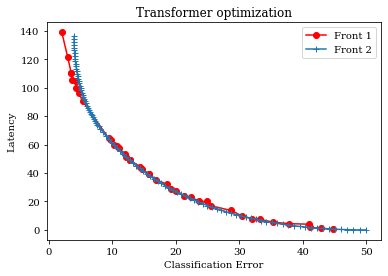

In [142]:
# sorted_array = an_array[numpy.argsort(an_array[:, 1])]
# plt.scatter(list(f2), list(f1), marker='o')
frontx = np.array(f1)
fronty = np.array(f2)

front = np.array([f1,f2])
# pd.DataFrame(front).to_csv("front.csv")

f1_ = frontx[list(idx[0])]
f2_ = fronty[list(idx[0])]
indexs_to_order_by = f1_.argsort()
f1_ = f1_[indexs_to_order_by]
f2_ = f2_[indexs_to_order_by]

# front_greedy1 = f1_
# front_greedy2 = f2_
# pd.DataFrame([f1_,f2_]).to_csv("front1.csv")

print(front)

# plt.ylim(12,15)
plt.plot(f2_, f1_, marker='o', color='r')


# f1_ = frontx[list(idx[1])]
# f2_ = fronty[list(idx[1])]
# indexs_to_order_by = f1_.argsort()
# f1_ = f1_[indexs_to_order_by]
# f2_ = f2_[indexs_to_order_by]
plt.plot(problem.pareto_front()[:,1], problem.pareto_front()[:,0], marker='+')

# f1_ = frontx[list(idx[2])]
# f2_ = fronty[list(idx[2])]
# indexs_to_order_by = f1_.argsort()
# f1_ = f1_[indexs_to_order_by]
# f2_ = f2_[indexs_to_order_by]
# plt.plot(f2_, f1_, marker='^')

plt.legend(['Front 1', 'Front 2', 'Front 3', 'Front 4'], loc='best')
plt.ylabel('Latency')
plt.xlabel('Classification Error')
plt.title('Transformer optimization')

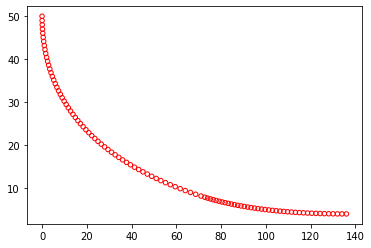

In [78]:
from pymoo.factory import get_problem
from pymoo.util.plotting import plot

problem = get_problem("bnh")
plot(problem.pareto_front(), no_fill=True)

list(problem.evaluate([3,5])[0])

def fitnessFunction (X):
  return list(problem.evaluate(X)[0])
  # return transformerFit(X)


0.019942522048950195


Text(0.5, 1.0, 'Binh & Korn function')

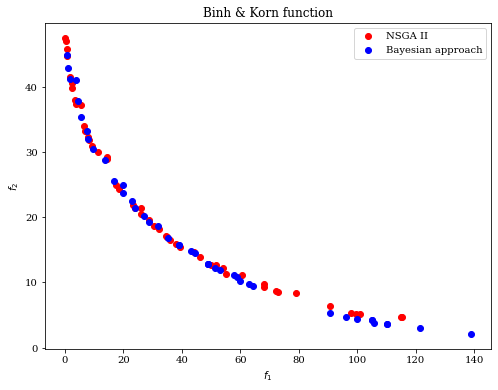

In [148]:
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.factory import get_problem, get_sampling, get_crossover, get_mutation
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.util.misc import stack
from pymoo.model.problem import Problem



tic = time.time()
algorithm = NSGA2(pop_size=50)

res = minimize(problem,
               algorithm,
               ('n_gen', 3),
               seed=1,
               verbose=False)
latency = time.time() - tic
print(latency)
plot = Scatter()
# plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.1)
plot.add(res.F, color="red")
plot.show()
problem.pareto_front()[:,1]

plt.scatter(f1_, f2_, marker='o', color='b')

plt.legend(['NSGA II', 'Bayesian approach'], loc='best')
plt.title('Binh & Korn function')